In [1]:
pip install tensorflow

     |████████████████████████████████| 479.6MB 3.3MB/s eta 0:00:012     |███████████████████████████████▎| 469.0MB 2.0MB/s eta 0:00:06
     |████████████████████████████████| 24.5MB 3.2MB/s eta 0:00:01
     |████████████████████████████████| 829kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 61kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 450kB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 143kB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 1.0MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 1.7MB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 2.4MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 4.8MB 1.3MB/s eta 0:00:01
     |████████████████████████████████| 296kB 1.5MB/s eta 0:00:01
     |

     |████████████████████████████████| 235kB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 184kB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 122kB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 163kB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 143kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 71kB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 92kB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 153kB 1.5MB/s eta 0:00:01
ERROR: sqlalchemy 2.0.28 has requirement typing-extensions>=4.6.0, but you'll have typing-extensions 4.5.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement importlib-metadata!=4.7.0,<7,>=3.7.0, but you'll have importlib-metadata 7.1.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement packaging<24, but you'll have packaging 24.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement pytz<2024, but you'll have pytz 2024.1 which is incompatible.
ERRO

In [2]:
pip install seaborn

     |████████████████████████████████| 296kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 9.2MB 26.2MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 48.4MB/s eta 0:00:01
     |████████████████████████████████| 12.4MB 52.5MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 54.2MB/s eta 0:00:01
     |████████████████████████████████| 307kB 60.0MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 52.3MB/s eta 0:00:01
     |████████████████████████████████| 112kB 35.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 48.9MB/s eta 0:00:01
     |████████████████████████████████| 4.7MB 44.6MB/s eta 0:00:01
     |████████████████████████████████| 235kB 42.2MB/s eta 0:00:01
     |████████████████████████████████| 348kB 36.3MB/s eta 0:00:01
     |████████████████████████████████| 512kB 41.6MB/s eta 0:00:01
ERROR: refractio 2.1.5.4 has requirement pandas==2.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: mlflow 2.6.0 h

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import time
import seaborn as sns
from snowflake.snowpark.session import Session
import configparser

import warnings
warnings.filterwarnings("ignore")

config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    "account": f'{config["Snowflake"]["account"]}',
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

Matplotlib created a temporary cache directory at /tmp/matplotlib-kmt362dt because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


connection successful!


In [2]:
df = session.table("CPG_WAREHOUSE").to_pandas()

In [3]:
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350001 entries, 0 to 350000
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATE                          350001 non-null  object 
 1   WARE_HOUSE_ID                 350001 non-null  object 
 2   WH_MANAGER_ID                 350001 non-null  object 
 3   LOCATION_TYPE                 350001 non-null  object 
 4   WH_CAPACITY_SIZE              350001 non-null  object 
 5   ZONE                          350001 non-null  object 
 6   WH_REGIONAL_ZONE              350001 non-null  object 
 7   REFILL_REQUESTS               350001 non-null  int8   
 8   TRANSPORT_ISSUE               350001 non-null  int8   
 9   NO_OF_COMPETITOR              350001 non-null  int8   
 10  NO_OF_RETAILERS               350001 non-null  int16  
 11  WAREHOUSE_OWNERSHIP           350001 non-null  object 
 12  NUMBER_OF_DISTRIBUTORS        350001 non-nul

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
REFILL_REQUESTS,350001.0,4.720761,3.648191,0.0,2.00,4.0,7.0,26.0
TRANSPORT_ISSUE,350001.0,2.426333,2.579299,0.0,0.00,2.0,4.0,22.0
NO_OF_COMPETITOR,350001.0,3.729101,2.997011,0.0,2.00,3.0,5.0,22.0
NO_OF_RETAILERS,350001.0,4985.876377,1285.713090,0.0,4141.00,4893.0,5724.0,12861.0
NUMBER_OF_DISTRIBUTORS,350001.0,61.922032,21.646701,8.0,46.00,62.0,77.0,146.0
FLOOD_IMPACTED,350001.0,0.098160,0.297531,0.0,0.00,0.0,0.0,1.0
FLOOD_PROOF,350001.0,0.054643,0.227282,0.0,0.00,0.0,0.0,1.0
ELECTRIC_SUPPLY,350001.0,0.656881,0.474752,0.0,0.00,1.0,1.0,1.0
DIST_FROM_HUB,350001.0,163.537113,62.717475,55.0,109.00,164.0,218.0,271.0
WORKERS_NUM,349011.0,37.665369,11.993045,0.0,30.00,37.0,45.0,124.0


In [5]:
df.duplicated().sum()
df.isnull().sum()

DATE                                 0
WARE_HOUSE_ID                        0
WH_MANAGER_ID                        0
LOCATION_TYPE                        0
WH_CAPACITY_SIZE                     0
ZONE                                 0
WH_REGIONAL_ZONE                     0
REFILL_REQUESTS                      0
TRANSPORT_ISSUE                      0
NO_OF_COMPETITOR                     0
NO_OF_RETAILERS                      0
WAREHOUSE_OWNERSHIP                  0
NUMBER_OF_DISTRIBUTORS               0
FLOOD_IMPACTED                       0
FLOOD_PROOF                          0
ELECTRIC_SUPPLY                      0
DIST_FROM_HUB                        0
WORKERS_NUM                        990
WH_EST_YEAR                     166335
STORAGE_ISSUE_REPORTED               0
TEMP_REG_MACH                        1
APPROVED_WH_GOVT_CERTIFICATE         1
WH_BREAKDOWN                         1
GOVT_CHECK                           1
PRODUCT_WG_TON                       1
dtype: int64

<Axes: >

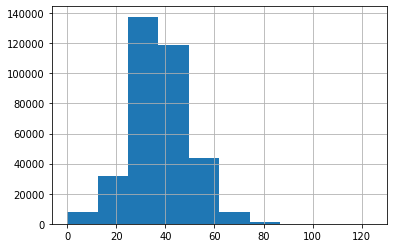

In [6]:
df['WORKERS_NUM'].hist()

In [7]:
df['WORKERS_NUM'] = df['WORKERS_NUM'].fillna(df['WORKERS_NUM'].mean())

APPROVED_WH_GOVT_CERTIFICATE
C     77014
B+    68837
B     67368
A     65394
A+    58674
NA    12712
0         1
Name: count, dtype: int64

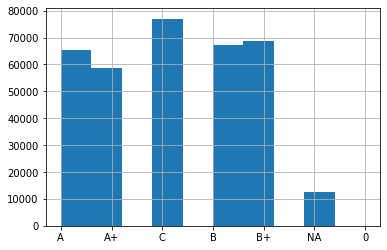

In [8]:
df['APPROVED_WH_GOVT_CERTIFICATE'].hist()
df['APPROVED_WH_GOVT_CERTIFICATE'].value_counts()

In [9]:
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != 'NA']

[Text(0.5, 1.0, 'Location Type by zone')]

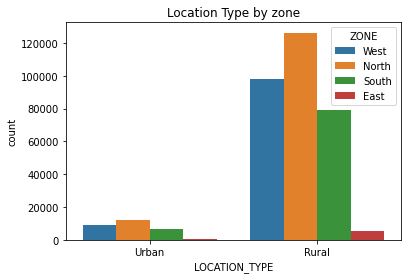

In [10]:
sns.countplot(data=df,x='LOCATION_TYPE',hue='ZONE').set(title='Location Type by zone')

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

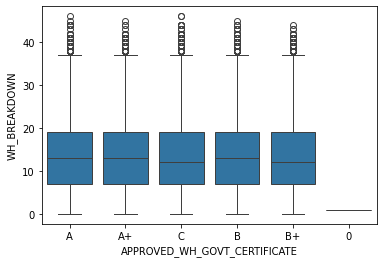

In [11]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [12]:
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != '0']

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

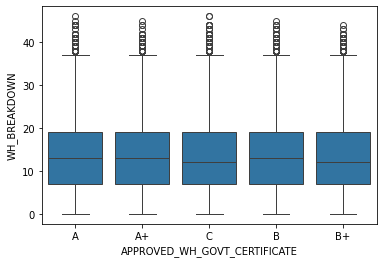

In [13]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [14]:
#label encoder turns label into numeric data
le = LabelEncoder()
df['LOCATION_TYPE']=le.fit_transform(df['LOCATION_TYPE'])
df['WH_CAPACITY_SIZE']=le.fit_transform(df['WH_CAPACITY_SIZE'])
df['APPROVED_WH_GOVT_CERTIFICATE']=le.fit_transform(df['APPROVED_WH_GOVT_CERTIFICATE'])
df['ZONE']=le.fit_transform(df['ZONE'])
df['WH_REGIONAL_ZONE']= le.fit_transform(df['WH_REGIONAL_ZONE'])
df['WAREHOUSE_OWNERSHIP']=le.fit_transform(df['WAREHOUSE_OWNERSHIP'])
## can also use the code below to transform into numeric data by removing "Zone" using lambda expression
##df['WH_regional_zone']=df['WH_regional_zone'].apply(lambda x: x.split(' ')[1]-1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337288 entries, 0 to 350000
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATE                          337288 non-null  object 
 1   WARE_HOUSE_ID                 337288 non-null  object 
 2   WH_MANAGER_ID                 337288 non-null  object 
 3   LOCATION_TYPE                 337288 non-null  int64  
 4   WH_CAPACITY_SIZE              337288 non-null  int64  
 5   ZONE                          337288 non-null  int64  
 6   WH_REGIONAL_ZONE              337288 non-null  int64  
 7   REFILL_REQUESTS               337288 non-null  int8   
 8   TRANSPORT_ISSUE               337288 non-null  int8   
 9   NO_OF_COMPETITOR              337288 non-null  int8   
 10  NO_OF_RETAILERS               337288 non-null  int16  
 11  WAREHOUSE_OWNERSHIP           337288 non-null  int64  
 12  NUMBER_OF_DISTRIBUTORS        337288 non-null  in

In [16]:
df = df.drop(['WARE_HOUSE_ID','WH_MANAGER_ID','DATE'],axis=1)

<Axes: >

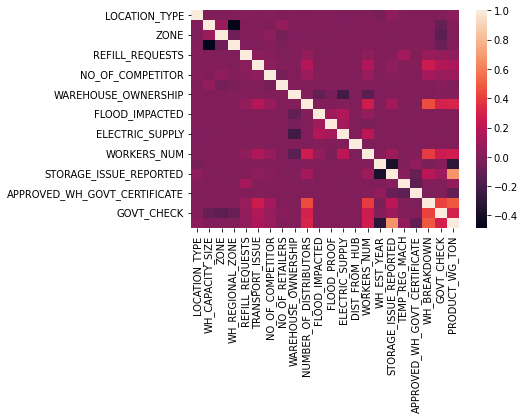

In [17]:
sns.heatmap(df.corr())


<class 'pandas.core.frame.DataFrame'>
Index: 337288 entries, 0 to 350000
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATE                          337288 non-null  object 
 1   WARE_HOUSE_ID                 337288 non-null  object 
 2   WH_MANAGER_ID                 337288 non-null  object 
 3   LOCATION_TYPE                 337288 non-null  int64  
 4   WH_CAPACITY_SIZE              337288 non-null  int64  
 5   ZONE                          337288 non-null  int64  
 6   WH_REGIONAL_ZONE              337288 non-null  int64  
 7   REFILL_REQUESTS               337288 non-null  int8   
 8   TRANSPORT_ISSUE               337288 non-null  int8   
 9   NO_OF_COMPETITOR              337288 non-null  int8   
 10  NO_OF_RETAILERS               337288 non-null  int16  
 11  WAREHOUSE_OWNERSHIP           337288 non-null  int64  
 12  NUMBER_OF_DISTRIBUTORS        337288 non-null  in

In [18]:
X = df.drop('APPROVED_WH_GOVT_CERTIFICATE',axis=1).values
y = df['APPROVED_WH_GOVT_CERTIFICATE'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
scaler = MinMaxScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [20]:
print('X train shape: ',X_train.shape)
print('X test shape: ',X_test.shape)

X train shape:  (269830, 21)
X test shape:  (67458, 21)


In [23]:
#define a deep learning model
model = Sequential()

#20 neurons first layer because 20 inputs
model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))

#5 neurons for last layer because 5 classes (grade of govt certificate)
model.add(Dense(6,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
#fit the model with data
history = model.fit(x=X_train,
          y=y_train, epochs=30,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/30
8433/8433 [==============================] - 16s 2ms/step - loss: nan - accuracy: 0.1936 - val_loss: nan - val_accuracy: 0.1951
Epoch 2/30
8433/8433 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.1936 - val_loss: nan - val_accuracy: 0.1951
Epoch 3/30
8433/8433 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.1936 - val_loss: nan - val_accuracy: 0.1951
Epoch 4/30
8433/8433 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.1936 - val_loss: nan - val_accuracy: 0.1951
Epoch 5/30
8433/8433 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.1936 - val_loss: nan - val_accuracy: 0.1951
Epoch 6/30
8433/8433 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.1936 - val_loss: nan - val_accuracy: 0.1951
Epoch 7/30
8433/8433 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.1936 - val_loss: nan - val_accuracy: 0.1951
Epoch 8/30
8433/8433 [=====